<h1>Time Domain Simphony Pole Residue Model</h1>

This notebook contains the method to simulating active components in a circuit through the usage of complex vector fitting. With the state space model created it can then be linked to other components through the class Time System to model the circuit.

The Pole residue Model of IIRModelBasebad exists in the simphony.time_domain.pole_residue_model



In [11]:
import numpy as np
import matplotlib.pyplot as plt
import sax
import jax.numpy as jnp
from jax import config
config.update("jax_enable_x64", True)

from simphony.libraries import ideal
from simphony.utils import dict_to_matrix
from simphony.time_domain.utils import gaussian_pulse
from simphony.time_domain.pole_residue_model import IIRModelBaseband
from simphony.time_domain.utils import pole_residue_to_time_system
from simphony.libraries import siepic



# Pole Residual Model Example

Instantiation of the active component must be done. How this component functions can be as needed but a netlist containing its components needs to be created and then the s_params taken from the circuit These are then passed into the IIRBasebandModel along with the specific parameters that the user would use such as:




In [3]:

netlist = {
    "instances": {
        "wg": "waveguide",
        "hr": "half_ring",
    },
    "connections": {
        "hr,o2": "wg,o0",
        "hr,o3": "wg,o1",
    },
    "ports": {
        "o0": "hr,o0",
        "o1": "hr,o1",
    }
}

circuit, info = sax.circuit(
    netlist=netlist,
    models={
        "waveguide": ideal.waveguide,
        "half_ring": ideal.coupler,
    }
)


In [4]:
num_measurements = 200
model_order = 50
center_wvl = 1.548  # Center wavelength (µm)
wvl = np.linspace(1.5, 1.6, num_measurements)  # Wavelength range (µm)

# Perform simulation
s = circuit(wl=wvl, wg={"length": 77.0, "loss": 100})
S = np.asarray(dict_to_matrix(s))  # Convert the result to a matrix
model = IIRModelBaseband(wvl, center_wvl, S, model_order)


In [5]:

N = int(1000)  # Number of time steps
T = 4e-11      # Total time duration (40 ps)
t = jnp.linspace(0, T, N)  # Time array
t0 = T/2 - 5e-12  # Pulse start time
std = 1e-12       # Pulse standard deviation

# Define input signals
impulse_pass = {
    'o0': gaussian_pulse(t, t0 - 0.5 * t0, std),
    'o1': jnp.zeros_like(t)
}

# Convert frequency domain model to a time-domain system
tsys = pole_residue_to_time_system(model)


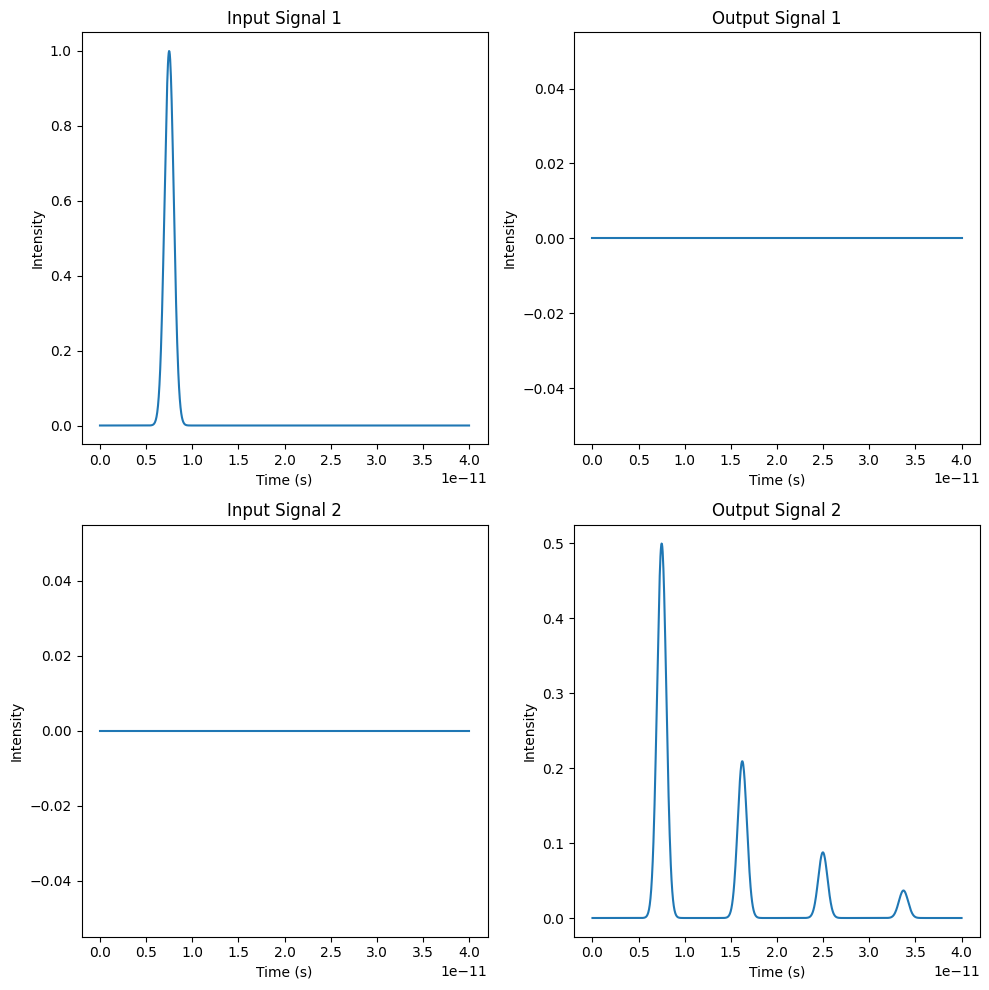

In [6]:
# Simulate the system's response to the input signals
outputs = tsys.response(impulse_pass)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows, 2 columns

# Plot input signals
for i in range(2):
    axs[i, 0].plot(t, jnp.abs(impulse_pass[f'o{i}'])**2)
    axs[i, 0].set_title(f'Input Signal {i+1}')
    axs[i, 0].set_xlabel('Time (s)')
    axs[i, 0].set_ylabel('Intensity')

# Plot output signals
for i in range(2):
    axs[i, 1].plot(t, jnp.abs(outputs[f'o{i}'])**2)
    axs[i, 1].set_title(f'Output Signal {i+1}')
    axs[i, 1].set_xlabel('Time (s)')
    axs[i, 1].set_ylabel('Intensity')

# Adjust layout
plt.tight_layout()
plt.show()

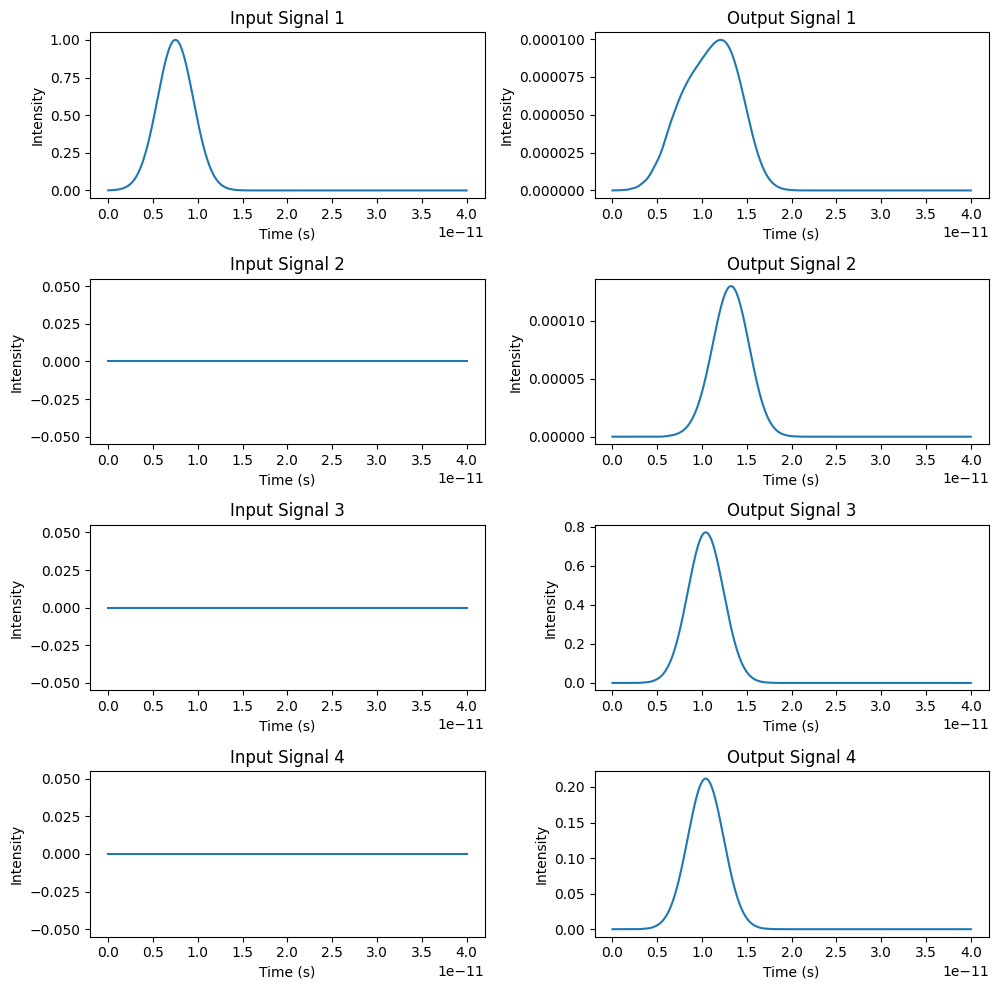

In [47]:
# Define the splitter and combiner using directional couplers

# Define the netlist for a Mach-Zehnder Modulator

netlist = {
    "instances": {
        "coupler": "coupler",  # The coupler instance
    },
    "connections": {},  # No internal connections for a single component
    "ports": {
        "o0": "coupler,port_1",   # First input port
        "o1": "coupler,port_2",   # Second input port
        "o2": "coupler,port_3",  # First output port
        "o3": "coupler,port_4",  # Second output port
    },

}


circuit, info = sax.circuit(
    netlist=netlist,
    models={
        "coupler": siepic.directional_coupler,
    }
)


num_measurements = 200
model_order = 50
center_wvl = 1.548  # Center wavelength (µm)
wvl = np.linspace(1.5, 1.6, num_measurements)  # Wavelength range (µm)


# Perform simulation
s = circuit(wl=wvl, wg={"length": 77.0, "loss": 1})
S = np.asarray(dict_to_matrix(s))  # Convert the result to a matrix
model = IIRModelBaseband(wvl, center_wvl, S, model_order)


N = int(1000)  # Number of time steps
T = 4e-11      # Total time duration (40 ps)
t = jnp.linspace(0, T, N)  # Time array
t0 = T/2 - 5e-12  # Pulse start time
std = 4e-12       # Pulse standard deviation


# Define input signals
impulse_pass = {
    'o0': gaussian_pulse(t, t0 - 0.5 * t0, std),
    'o1': jnp.zeros_like(t),
    'o2': jnp.zeros_like(t),
    'o3': jnp.zeros_like(t),
}


# Convert frequency domain model to a time-domain system
tsys = pole_residue_to_time_system(model)
# Simulate the system's response to the input signals
outputs = tsys.response(impulse_pass)


# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(10, 10))  # 2 rows, 2 columns


# Plot input signals
for i in range(4):
    axs[i, 0].plot(t, jnp.abs(impulse_pass[f'o{i}'])**2)
    axs[i, 0].set_title(f'Input Signal {i+1}')
    axs[i, 0].set_xlabel('Time (s)')
    axs[i, 0].set_ylabel('Intensity')


# Plot output signals
for i in range(4):
    axs[i, 1].plot(t, jnp.abs(outputs[f'o{i}'])**2)
    axs[i, 1].set_title(f'Output Signal {i+1}')
    axs[i, 1].set_xlabel('Time (s)')
    axs[i, 1].set_ylabel('Intensity')


# Adjust layout
plt.tight_layout()
plt.show()


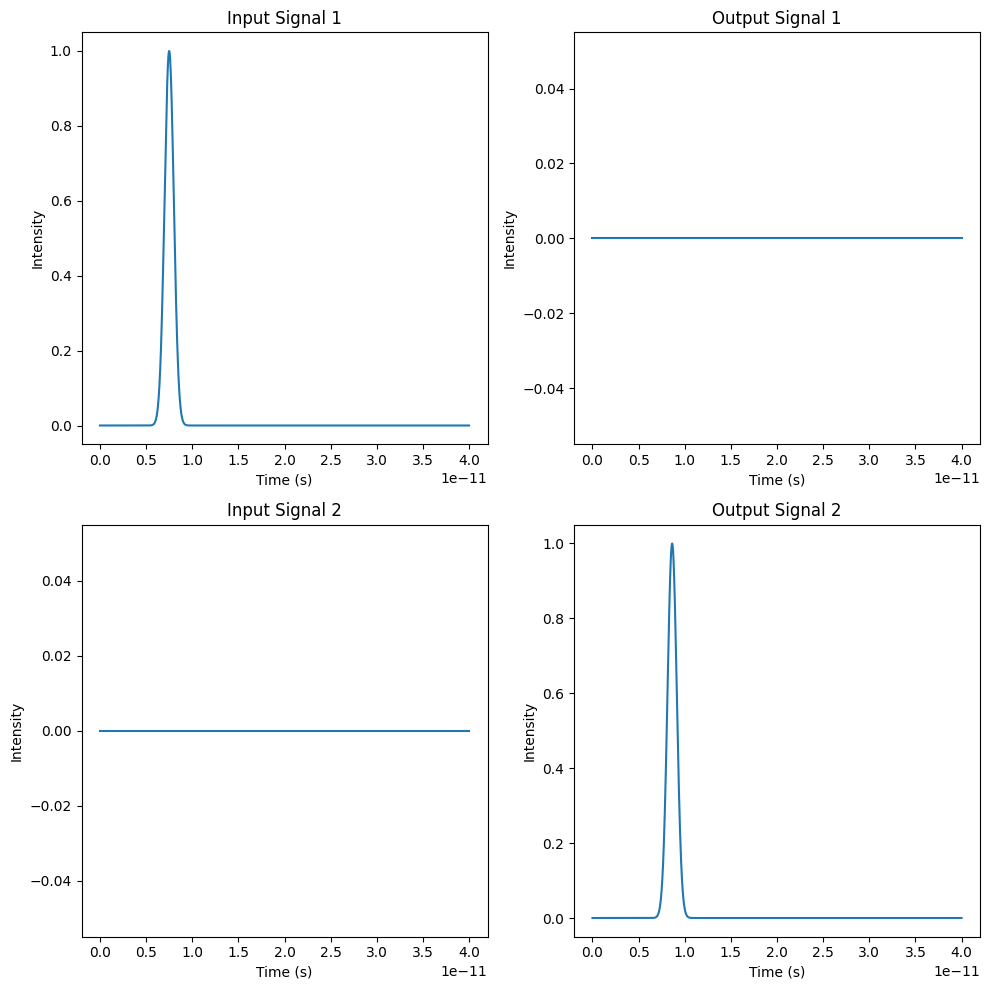

In [ ]:
netlist = {
    "instances": {
        "coupler": "coupler",  # The coupler instance
    },
    "connections": {},  # No internal connections for a single component
    "ports": {
        "o0": "coupler,o0",   # First input port
        "o1": "coupler,o1",   # Second input port
    },

}


circuit, info = sax.circuit(
    netlist=netlist,
    models={
        "coupler": ideal.waveguide,
    }
)


num_measurements = 200
model_order = 50
center_wvl = 1.548  # Center wavelength (µm)
wvl = np.linspace(1.5, 1.6, num_measurements)  # Wavelength range (µm)


# Perform simulation
s = circuit(wl=wvl, wg={"length": 77.0, "loss": 100})
S = np.asarray(dict_to_matrix(s))  # Convert the result to a matrix
model = IIRModelBaseband(wvl, center_wvl, S, model_order)


N = int(1000)  # Number of time steps
T = 4e-11      # Total time duration (40 ps)
t = jnp.linspace(0, T, N)  # Time array
t0 = T/2 - 5e-12  # Pulse start time
std = 1e-12       # Pulse standard deviation


# Define input signals
impulse_pass = {
    'o0': gaussian_pulse(t, t0 - 0.5 * t0, std),
    'o1': jnp.zeros_like(t)
}


# Convert frequency domain model to a time-domain system
tsys = pole_residue_to_time_system(model)
# Simulate the system's response to the input signals
outputs = tsys.response(impulse_pass)


# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows, 2 columns


# Plot input signals
for i in range(2):
    axs[i, 0].plot(t, jnp.abs(impulse_pass[f'o{i}'])**2)
    axs[i, 0].set_title(f'Input Signal {i+1}')
    axs[i, 0].set_xlabel('Time (s)')
    axs[i, 0].set_ylabel('Intensity')


# Plot output signals
for i in range(2):
    axs[i, 1].plot(t, jnp.abs(outputs[f'o{i}'])**2)
    axs[i, 1].set_title(f'Output Signal {i+1}')
    axs[i, 1].set_xlabel('Time (s)')
    axs[i, 1].set_ylabel('Intensity')


# Adjust layout
plt.tight_layout()
plt.show()


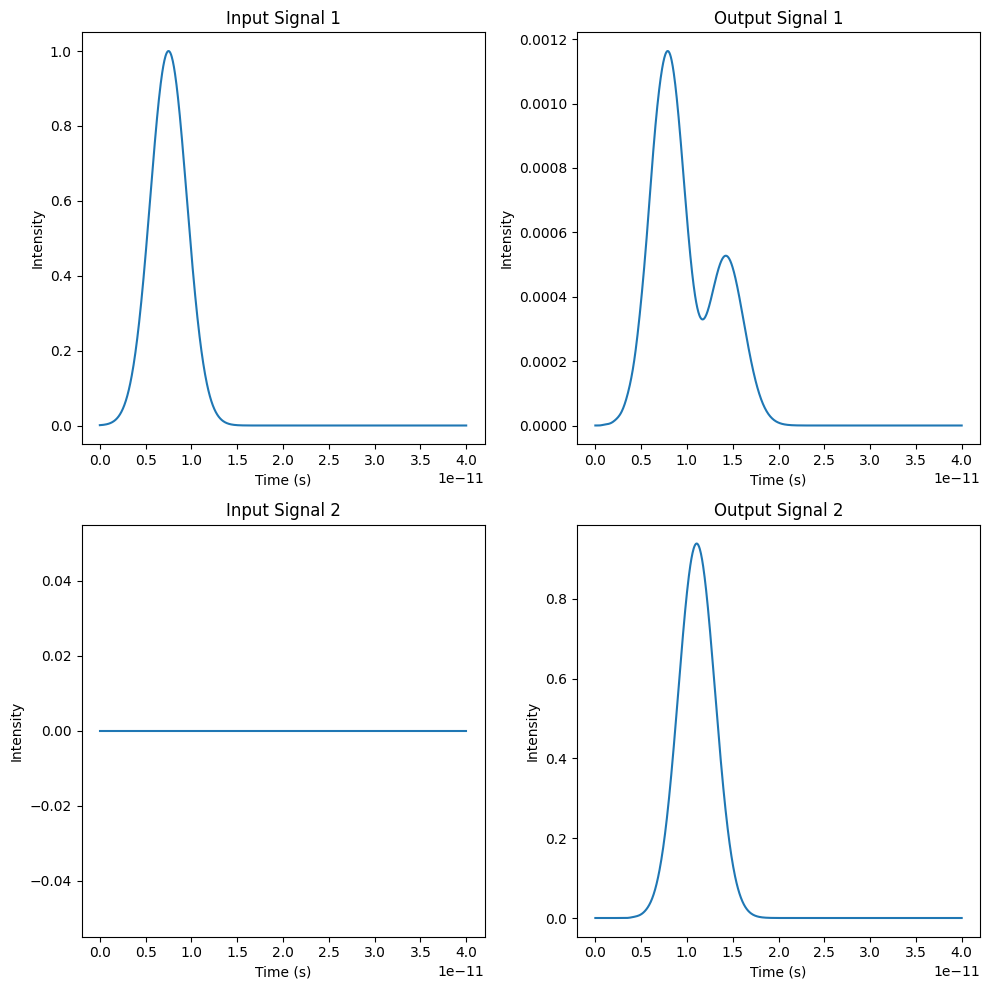

In [46]:
# Define the splitter and combiner using directional couplers

# Define the netlist for a Mach-Zehnder Modulator

netlist = {
    "instances": {
        "cr1": "y_branch",
        "cr2": "y_branch",# The coupler instance
        "wg1": "waveguide",
        "wg2": "waveguide",
    },
    "connections": {
        "cr1,port_2":"wg1,o0",
        "cr1,port_3":"wg2,o0",
        "wg1,o1":"cr2,port_2",
        "wg2,o1":"cr2,port_3",

    },  # No internal connections for a single component
    "ports": {
        "o0": "cr1,port_1",   # First input port   # Second input port
        "o1": "cr2,port_1",  # First output port  # Second output port
    },

}


circuit, info = sax.circuit(
    netlist=netlist,
    models={
        "y_branch": siepic.y_branch,
        "waveguide":siepic.waveguide,

    }
)


num_measurements = 200
model_order = 50
center_wvl = 1.548  # Center wavelength (µm)
wvl = np.linspace(1.5, 1.6, num_measurements)  # Wavelength range (µm)


# Perform simulation
s = circuit(wl=wvl, wg={"length": 77.0, "loss": 1})
S = np.asarray(dict_to_matrix(s))  # Convert the result to a matrix
model = IIRModelBaseband(wvl, center_wvl, S, model_order)


N = int(1000)  # Number of time steps
T = 4e-11      # Total time duration (40 ps)
t = jnp.linspace(0, T, N)  # Time array
t0 = T/2 - 5e-12  # Pulse start time
std = 4e-12       # Pulse standard deviation


# Define input signals
impulse_pass = {
    'o0': gaussian_pulse(t, t0 - 0.5 * t0, std),
    'o1': jnp.zeros_like(t),
    
}


# Convert frequency domain model to a time-domain system
tsys = pole_residue_to_time_system(model)
# Simulate the system's response to the input signals
outputs = tsys.response(impulse_pass)


# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows, 2 columns


# Plot input signals
for i in range(2):
    axs[i, 0].plot(t, jnp.abs(impulse_pass[f'o{i}'])**2)
    axs[i, 0].set_title(f'Input Signal {i+1}')
    axs[i, 0].set_xlabel('Time (s)')
    axs[i, 0].set_ylabel('Intensity')


# Plot output signals
for i in range(2):
    axs[i, 1].plot(t, jnp.abs(outputs[f'o{i}'])**2)
    axs[i, 1].set_title(f'Output Signal {i+1}')
    axs[i, 1].set_xlabel('Time (s)')
    axs[i, 1].set_ylabel('Intensity')


# Adjust layout
plt.tight_layout()
plt.show()


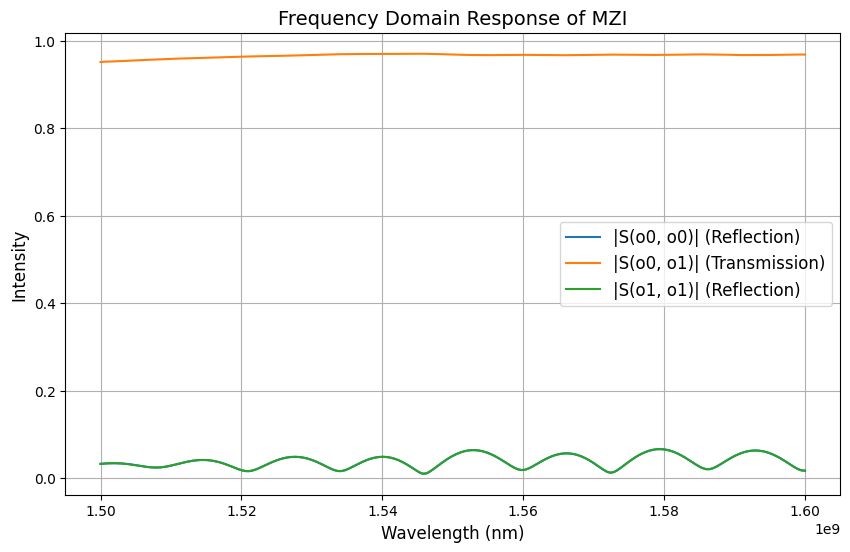

In [ ]:
from simphony.libraries.siepic.models import y_branch, waveguide

import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, ifft, fftfreq

# Define the frequency range for the MZI simulation

# Define components for MZI
netlist = {
    "instances": {
        "cr1": "y_branch",
        "cr2": "y_branch",
        "wg1": "waveguide",
        "wg2": "waveguide",
    },
    "connections": {
        "cr1,port_2":"wg1,o0",
        "cr1,port_3":"wg2,o0",
        "wg1,o1":"cr2,port_2",
        "wg2,o1":"cr2,port_3",

    },  # No internal connections for a single component
    "ports": {
        "o0": "cr1,port_1",   # First input port   # Second input port
        "o1": "cr2,port_1",  # First output port  # Second output port
    },

}


circuit, info = sax.circuit(
    netlist=netlist,
    models={
        "y_branch": siepic.y_branch,
        "waveguide": siepic.waveguide,

    }
)
num_measurements = 200
model_order = 50
center_wvl = 1.548  # Center wavelength (µm)
wvl = np.linspace(1.5, 1.6, num_measurements)  # Wavelength range (µm)


# Perform simulation
s = circuit(wl=wvl, wg={"length": 77.0, "loss": 1})
s_o0_o0 = np.array(s[("o0", "o0")])  # Reflection at o0
s_o0_o1 = np.array(s[("o0", "o1")])  # Transmission from o1 to o0
s_o1_o1 = np.array(s[("o1", "o1")])  # Reflection at o1

# Compute magnitudes
mag_o0_o0 = np.abs(s_o0_o0)
mag_o0_o1 = np.abs(s_o0_o1)
mag_o1_o1 = np.abs(s_o1_o1)

# Plot the frequency-domain response
plt.figure(figsize=(10, 6))
plt.plot(wvl * 1e9, mag_o0_o0, label="|S(o0, o0)| (Reflection)")
plt.plot(wvl * 1e9, mag_o0_o1, label="|S(o0, o1)| (Transmission)")
plt.plot(wvl * 1e9, mag_o1_o1, label="|S(o1, o1)| (Reflection)")
plt.xlabel("Wavelength (nm)", fontsize=12)
plt.ylabel("Intensity", fontsize=12)
plt.title("Frequency Domain Response of MZI", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


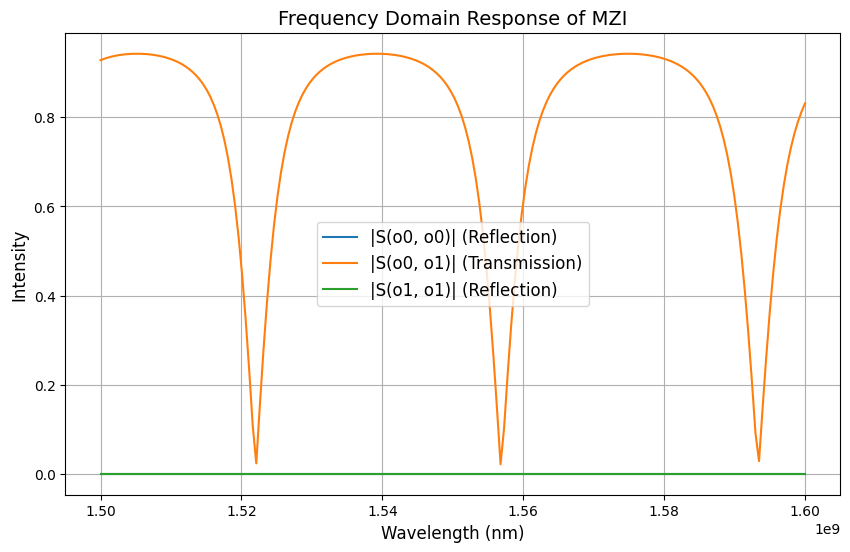

In [35]:
from simphony.libraries.siepic.models import y_branch, waveguide

import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, ifft, fftfreq

# Define the frequency range for the MZI simulation

# Define components for MZI
netlist = {
    "instances": {
        "cr1": "coupler",
        "cr2": "coupler",
        "wg1": "waveguide",
        "wg2": "waveguide",
    },
    "connections": {
        "cr1,o2":"wg1,o0",
        "cr1,o3":"wg2,o0",
        "wg1,o1":"cr2,o0",
        "wg2,o1":"cr2,o1",

    },  # No internal connections for a single component
    "ports": {
        "o0": "cr1,o0",
        "o1": "cr1,o1",   # First input port   # Second input port
        "o2": "cr2,o2",
        "o3": "cr2,o3",  # First output port  # Second output port
    },

}


circuit, info = sax.circuit(
    netlist=netlist,
    models={
        "coupler": ideal.coupler,
        "waveguide": ideal.waveguide,

    }
)
num_measurements = 200
model_order = 50
center_wvl = 1.548  # Center wavelength (µm)
wvl = np.linspace(1.5, 1.6, num_measurements)  # Wavelength range (µm)


# Perform simulation
s = circuit(wl=wvl, wg={"length": 77.0, "loss": 1})
s_o0_o0 = np.array(s[("o0", "o0")])  # Reflection at o0
s_o0_o1 = np.array(s[("o0", "o1")])  # Transmission from o1 to o0
s_o1_o1 = np.array(s[("o1", "o1")])  # Reflection at o1

# Compute magnitudes
mag_o0_o0 = np.abs(s_o0_o0)
mag_o0_o1 = np.abs(s_o0_o1)
mag_o1_o1 = np.abs(s_o1_o1)

# Plot the frequency-domain response
plt.figure(figsize=(10, 6))
plt.plot(wvl * 1e9, mag_o0_o0, label="|S(o0, o0)| (Reflection)")
plt.plot(wvl * 1e9, mag_o0_o1, label="|S(o0, o1)| (Transmission)")
plt.plot(wvl * 1e9, mag_o1_o1, label="|S(o1, o1)| (Reflection)")
plt.xlabel("Wavelength (nm)", fontsize=12)
plt.ylabel("Intensity", fontsize=12)
plt.title("Frequency Domain Response of MZI", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


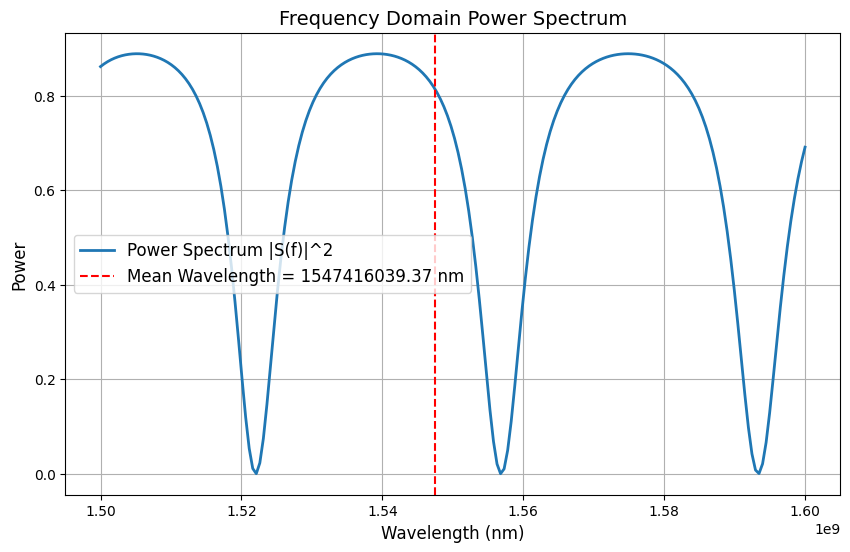

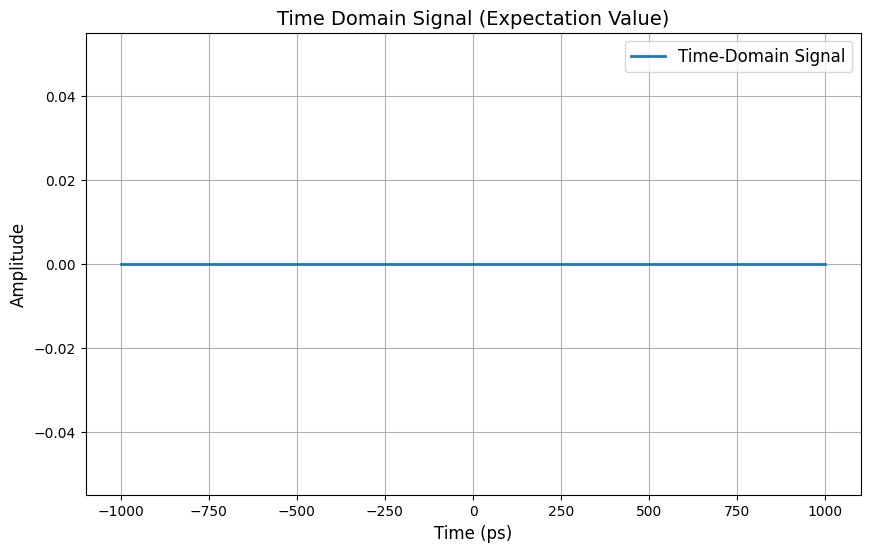

In [36]:
# Use the provided S-parameters for conversion
# Extracting |S(o0, o0)| as power spectrum


# Generate a frequency range matching the S-parameters
  # Wavelength in meters (dummy)

# Compute power spectrum
power_spectrum = np.abs(s_o0_o1)**2

# Calculate expectation values
mean_time = np.sum(wvl * power_spectrum) / np.sum(power_spectrum)
variance_time = np.sum((wvl - mean_time)**2 * power_spectrum) / np.sum(power_spectrum)
std_dev_time = np.sqrt(variance_time)

# Plot power spectrum
plt.figure(figsize=(10, 6))
plt.plot(wvl * 1e9, power_spectrum, label="Power Spectrum |S(f)|^2", linewidth=2)
plt.axvline(mean_time * 1e9, color='r', linestyle='--', label=f"Mean Wavelength = {mean_time * 1e9:.2f} nm")
plt.xlabel("Wavelength (nm)", fontsize=12)
plt.ylabel("Power", fontsize=12)
plt.title("Frequency Domain Power Spectrum", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Reconstruct time-domain signal as Gaussian
time = np.linspace(-1e-9, 1e-9, len(s_o0_o0))  # Time range
time_signal = np.exp(-(time - mean_time)**2 / (2 * variance_time))  # Gaussian approximation

# Plot time-domain signal
plt.figure(figsize=(10, 6))
plt.plot(time * 1e12, time_signal, label="Time-Domain Signal", linewidth=2)
plt.xlabel("Time (ps)", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.title("Time Domain Signal (Expectation Value)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


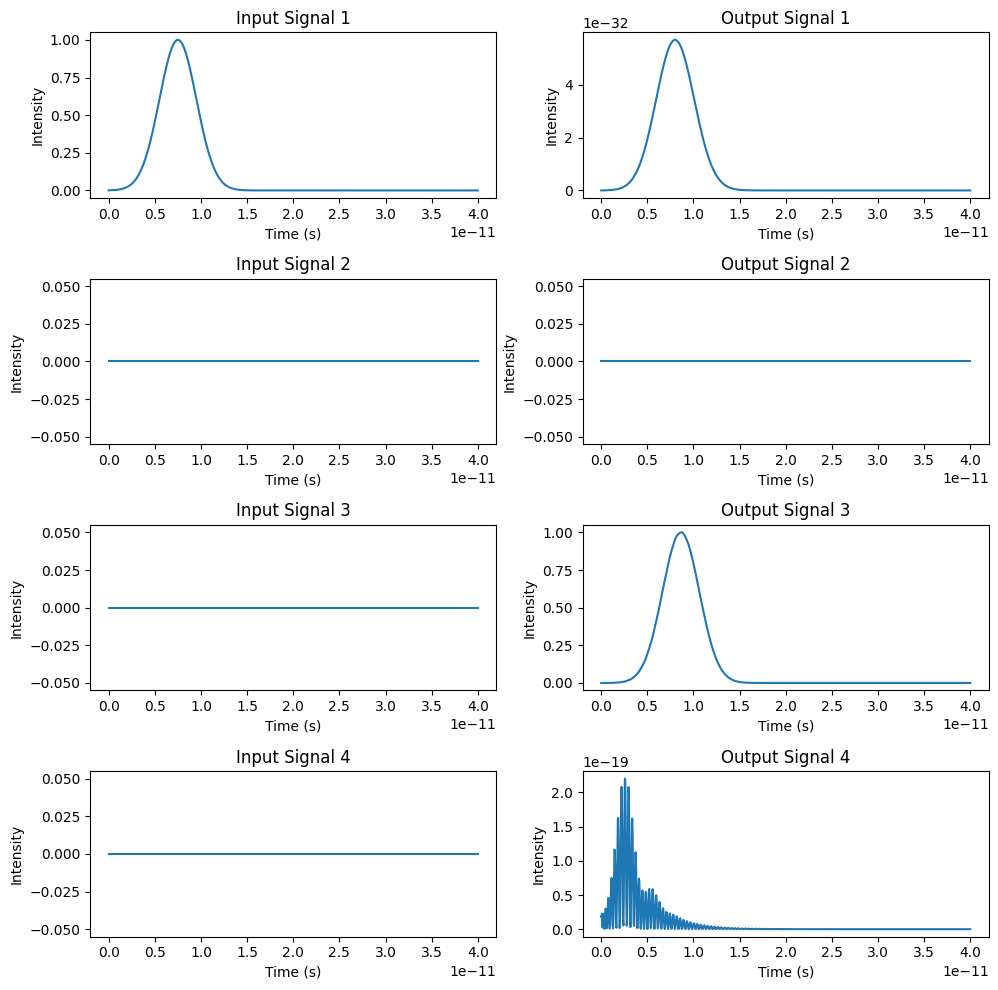

In [48]:
netlist = {
    "instances": {
        "cr1": "coupler",
        "cr2": "coupler",
        "wg1": "waveguide",
        "wg2": "waveguide",
    },
    "connections": {
        "cr1,o1":"wg1,o0",
        "cr1,o3":"wg2,o0",
        "wg1,o1":"cr2,o0",
        "wg2,o1":"cr2,o2",

    },  # No internal connections for a single component
    "ports": {
        "o0": "cr1,o0",
        "o1": "cr1,o2",   
        "o2": "cr2,o3",
        "o3": "cr2,o1",  
    },

}


circuit, info = sax.circuit(
    netlist=netlist,
    models={
        "coupler": ideal.coupler,
        "waveguide": ideal.waveguide,

    }
)
num_measurements = 200
model_order = 50
center_wvl = 1.548  # Center wavelength (µm)
wvl = np.linspace(1.5, 1.6, num_measurements)  # Wavelength range (µm)


# Perform simulation
s = circuit(wl=wvl, wg={"length": 77.0, "loss": 100})
S = np.asarray(dict_to_matrix(s))
model = IIRModelBaseband(wvl, center_wvl, S, model_order)


N = int(1000)  # Number of time steps
T = 4e-11      # Total time duration (40 ps)
t = jnp.linspace(0, T, N)  # Time array
t0 = T/2 - 5e-12  # Pulse start time
std = 4e-12       # Pulse standard deviation


# Define input signals
impulse_pass = {
    'o0': gaussian_pulse(t, t0 - 0.5 * t0, std),
    'o1': jnp.zeros_like(t),
    'o2': jnp.zeros_like(t),
    'o3': jnp.zeros_like(t),
}


# Convert frequency domain model to a time-domain system
tsys = pole_residue_to_time_system(model)
# Simulate the system's response to the input signals
outputs = tsys.response(impulse_pass)
ports = 4

# Create subplots
fig, axs = plt.subplots(ports, 2, figsize=(10, 10))  # 2 rows, 2 columns


# Plot input signals
for i in range(ports):
    axs[i, 0].plot(t, jnp.abs(impulse_pass[f'o{i}'])**2)
    axs[i, 0].set_title(f'Input Signal {i+1}')
    axs[i, 0].set_xlabel('Time (s)')
    axs[i, 0].set_ylabel('Intensity')


# Plot output signals
for i in range(ports):
    axs[i, 1].plot(t, jnp.abs(outputs[f'o{i}'])**2)
    axs[i, 1].set_title(f'Output Signal {i+1}')
    axs[i, 1].set_xlabel('Time (s)')
    axs[i, 1].set_ylabel('Intensity')


# Adjust layout
plt.tight_layout()
plt.show()


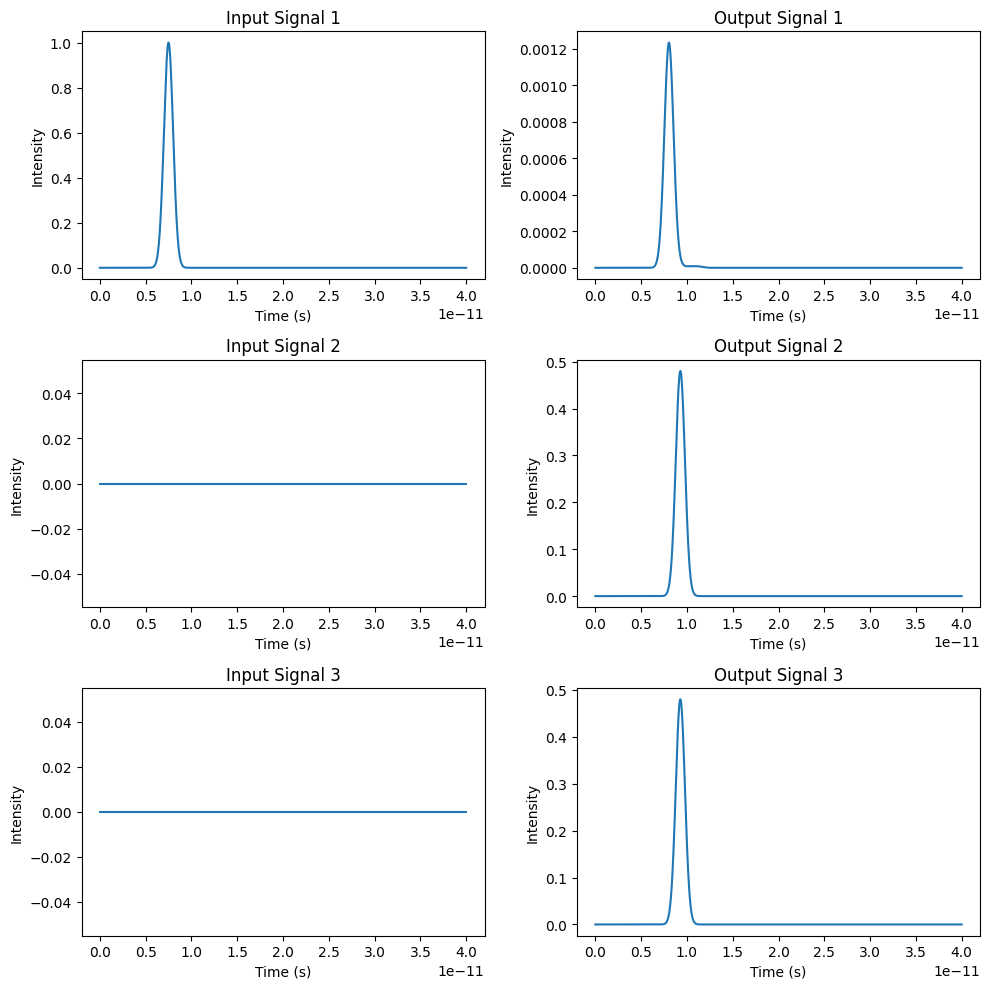

In [52]:
netlist = {
    "instances": {
        "coupler": "coupler",  # The coupler instance
    },
    "connections": {},  # No internal connections for a single component
    "ports": {
        "o0": "coupler,port_1",   # First input port
        "o1": "coupler,port_2",
        "o2": "coupler,port_3",
            
    },

}


circuit, info = sax.circuit(
    netlist=netlist,
    models={
        "coupler": siepic.y_branch,
    }
)


num_measurements = 200
model_order = 50
center_wvl = 1.548  # Center wavelength (µm)
wvl = np.linspace(1.5, 1.6, num_measurements)  # Wavelength range (µm)


# Perform simulation
s = circuit(wl=wvl, wg={"length": 77.0, "loss": 100})
S = np.asarray(dict_to_matrix(s))  # Convert the result to a matrix
model = IIRModelBaseband(wvl, center_wvl, S, model_order)


N = int(1000)  # Number of time steps
T = 4e-11      # Total time duration (40 ps)
t = jnp.linspace(0, T, N)  # Time array
t0 = T/2 - 5e-12  # Pulse start time
std = 1e-12       # Pulse standard deviation


# Define input signals
impulse_pass = {
    'o0': gaussian_pulse(t, t0 - 0.5 * t0, std),
    'o1': jnp.zeros_like(t),
    'o2': jnp.zeros_like(t),
}


# Convert frequency domain model to a time-domain system
tsys = pole_residue_to_time_system(model)
# Simulate the system's response to the input signals
outputs = tsys.response(impulse_pass)


# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 10))  # 2 rows, 2 columns


# Plot input signals
for i in range(3):
    axs[i, 0].plot(t, jnp.abs(impulse_pass[f'o{i}'])**2)
    axs[i, 0].set_title(f'Input Signal {i+1}')
    axs[i, 0].set_xlabel('Time (s)')
    axs[i, 0].set_ylabel('Intensity')


# Plot output signals
for i in range(3):
    axs[i, 1].plot(t, jnp.abs(outputs[f'o{i}'])**2)
    axs[i, 1].set_title(f'Output Signal {i+1}')
    axs[i, 1].set_xlabel('Time (s)')
    axs[i, 1].set_ylabel('Intensity')


# Adjust layout
plt.tight_layout()
plt.show()
